In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image
from matplotlib import pyplot as plt

In [6]:
# th architecture to use
arch = 'resnet50'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

In [7]:
model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        # trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
class_dict={}
with open(file_name) as class_file:
    for line in class_file:
        # print(line)
        val1 = line.strip().split(' ')[0][3:]
        val2 = line.strip().split(' ')[1]
        class_dict[val1] = val2
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

In [9]:
# load the test image
img_name = '1.jpg'
if not os.access(img_name, os.W_OK):
    img_url = 'http://places.csail.mit.edu/demo/' + img_name
    os.system('wget ' + img_url)

img = Image.open(img_name)
input_img = V(centre_crop(img).unsqueeze(0))

# forward pass
logit = model(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)

print('{} prediction on {}'.format(arch,img_name))
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

resnet50 prediction on 1.jpg
0.317 -> coast
0.193 -> beach
0.141 -> ocean
0.076 -> field/wild
0.056 -> boardwalk


	Predicted Class: coast


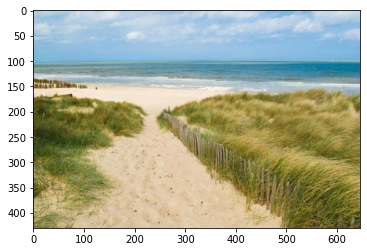

In [10]:
plt.imshow(img)
print('\tPredicted Class:', classes[idx[0]])

In [46]:
image_names = os.listdir('/content/drive/My Drive/00_openvino/interior_image/imagenet_new')
print(len(image_names))

41


In [47]:
image_names = image_names[:-1]
# print(image_names)

print(image_names)
print(len(image_names))

['art_gallery.jpg', 'archive.jpg', 'art_studio.jpg', 'attic.jpg', 'ballroom.jpg', 'basement.jpg', 'balcony.jpg', 'bedroom.jpg', 'bathroom.jpg', 'berth.jpg', 'classroom.jpg', 'closet.jpg', 'conference_room.jpg', 'corridor.jpg', 'dining_room.jpg', 'bow_window.jpg', 'childs_room.jpg', 'dorm_room.jpg', 'computer_room.jpg', 'gymnasium.jpg', 'engine_room.jpg', 'home_theater.jpg', 'entrance_hall.jpg', 'laundromat.jpg', 'lawn.jpg', 'kitchen.jpg', 'music_studio.jpg', 'locker_room.jpg', 'library.jpg', 'home_office.jpg', 'nursery.jpg', 'parking_lot.jpg', 'patio.jpg', 'porch.jpg', 'living_room.jpg', 'server_room.jpg', 'swimming_pool.jpg', 'operating_room.jpg', 'staircase.jpg', 'office_cubicles.jpg']
40


In [57]:
correct =0
for image_name in image_names:
  image = Image.open('/content/drive/My Drive/00_openvino/interior_image/imagenet_new/'+image_name)
  input_image = V(centre_crop(image).unsqueeze(0))

  # forward pass
  logit = model(input_image)
  h_x = F.softmax(logit, 1).data.squeeze()
  probs, idx = h_x.sort(0, True)

  print('\n\n{} prediction on {}'.format(arch,image_name))
  # output the prediction
  for i in range(0, 10):
      print('{}  {:.7f}'.format(classes[idx[i]], probs[i]))

  actual_class = image_name[:-4]
  print('Actual: ', actual_class, 'Predicted: ', classes[idx[0]])
  i=0
  for i in range(0, 5):
    if(actual_class == classes[idx[i]] or actual_class == classes[idx[i]].split('/')[0]):
      # print('Adding')
      correct +=1
      break

print('\n Top-5 Accuracy of the network on the 40 test images: %d %%' % (100 * correct / 40))



resnet50 prediction on art_gallery.jpg
art_gallery  0.4442620
artists_loft  0.3017283
art_studio  0.1002304
museum/indoor  0.0473928
booth/indoor  0.0162770
art_school  0.0158603
childs_room  0.0156937
kindergarden_classroom  0.0090641
lobby  0.0036041
playroom  0.0029809
Actual:  art_gallery Predicted:  art_gallery


resnet50 prediction on archive.jpg
archive  0.5434156
storage_room  0.4228305
bookstore  0.0101038
hardware_store  0.0042927
basement  0.0032667
library/indoor  0.0024852
general_store/indoor  0.0012383
chemistry_lab  0.0010474
physics_laboratory  0.0008135
server_room  0.0006943
Actual:  archive Predicted:  archive


resnet50 prediction on art_studio.jpg
storage_room  0.1981774
art_studio  0.1767218
gift_shop  0.1207301
dorm_room  0.0644957
general_store/indoor  0.0603729
kindergarden_classroom  0.0374488
art_school  0.0363119
basement  0.0361262
home_office  0.0266415
playroom  0.0236510
Actual:  art_studio Predicted:  storage_room


resnet50 prediction on attic.jpg
a

In [13]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import glob
import torch.nn as nn
import os.path as osp
import torchvision
import matplotlib.pyplot as plt



import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image
#import rotateImage
import cv2
import numpy as np
#import split_folders
import random
import torch.backends.cudnn as cudnn
import torch.optim as optim
from random import choice
from collections import OrderedDict

In [55]:
the_model = torch.load('/content/drive/My Drive/00_openvino/resnet50_places365.pth.tar')

In [ ]:
type(the_model)

In [ ]:
print(the_model.keys())

In [ ]:
the_model['epoch']

In [ ]:
arch = the_model['arch']

In [9]:
the_model['best_prec1']

NameError: ignored

In [20]:
import torchvision.models as models

def load_model(checkpoint_path):
  arch='resnet50'
  model = models.__dict__[arch](num_classes=365)
  checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
  state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
  model.load_state_dict(state_dict)
  # model.eval()
  model.fc = nn.Sequential(model.fc,nn.Softmax())

  

  # criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

  # net = torchvision.models.resnet50(pretrained = True)
  # net.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=365))
  # net.fc = nn.Sequential(*list(net.fc)+[nn.Softmax(1)])

  # model = models.__dict__[arch](num_classes=365)
  # checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)

  # state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
  # model.load_state_dict(state_dict)

  # print('type', type(model.fc))
  # model.fc = nn.Sequential(*list(model.fc)+[nn.Softmax(1)])
  # model = nn.Sequential(model.fc,nn.Softmax())
  # model.fc = nn.Sequential(
  #   *model.fc,
  #   nn.Softmax())
  # model.fc =  nn.Sequential(*model.fc, nn.Softmax())
  #nn.Sequential(OrderedDict([(model.fc),("softamx_layer", nn.Softmax())]))

  for param, x in model.named_parameters():
      x.requires_grad= False

  # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # model = model.to(device)

  return model

In [21]:
model_1 = load_model('http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar')

In [22]:
type(model_1)

torchvision.models.resnet.ResNet

In [23]:
print(model_1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
pip install onnx onnxruntime

     |████████████████████████████████| 7.4MB 4.0MB/s 
     |████████████████████████████████| 4.4MB 34.2MB/s 


In [14]:
import onnx

In [18]:
onnx_model = onnx.load("/content/drive/My Drive/00_openvino/resnet50_places365_img256.onnx")
print(type(onnx_model))
print(type(onnx.checker.check_model(onnx_model)))

<class 'onnx.onnx_ONNX_REL_1_7_ml_pb2.ModelProto'>
<class 'NoneType'>


In [42]:
img_name = '1.jpg'
if not os.access(img_name, os.W_OK):
    img_url = 'http://places.csail.mit.edu/demo/' + img_name
    os.system('wget ' + img_url)

In [43]:
# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        # trn.CenterCrop(224),
        trn.ToTensor(),
        # trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img = Image.open(img_name)
input_img = V(centre_crop(img).unsqueeze(0))

In [44]:
img1 = V(centre_crop(img))
print(input_img.shape)

torch.Size([1, 3, 256, 256])


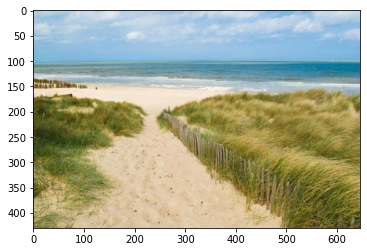

In [21]:
plt.imshow(img)

In [ ]:
print(input_img.shape)

torch.Size([1, 3, 224, 224])


In [45]:
# forward pass
logit = model_1.forward(input_img)
h_x_1 = F.softmax(logit, 1).data.squeeze()
probs_1, idx_1 = h_x_1.sort(0, True)
# print(idx)

print('{} prediction on {}'.format('resnet50',img_name))
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs_1[i], classes[idx_1[i]]))

resnet50 prediction on 1.jpg
0.576 -> beach
0.201 -> desert/vegetation
0.082 -> coast
0.053 -> ocean
0.021 -> wave


In [ ]:
for name, param in the_model.named_parameters():
    print(name, ':', param.requires_grad)

In [28]:
dummy_input = torch.randn(1, 3, 256, 256)
onnx_path =  "/content/drive/My Drive/00_openvino/resnet50_places365_image_size256.onnx"

torch.onnx.export(model, dummy_input, onnx_path, export_params=True, opset_version=10, verbose=False)
print('Model exported to ' + onnx_path)

Model exported to /content/drive/My Drive/00_openvino/resnet50_places365_image_size256.onnx


In [20]:
onnx_model = onnx.load("/content/drive/My Drive/00_openvino/resnet50_places365_resize256.onnx")
onnx.checker.check_model(onnx_model)

In [21]:
print(type(onnx_model))
print(type(onnx.checker.check_model(onnx_model)))

<class 'onnx.onnx_ONNX_REL_1_7_ml_pb2.ModelProto'>
<class 'NoneType'>


In [26]:
torch_out = model(dummy_input)

In [27]:
import onnxruntime


ort_session = onnxruntime.InferenceSession("/content/drive/My Drive/00_openvino/resnet50_places365_resize256.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [ ]:
dummy_input = torch.randn(1, 3, 256, 256)
onnx_path =  "/content/drive/My Drive/00_openvino/resnet50_places365_.onnx"

torch.onnx.export(model_1, dummy_input, onnx_path, verbose=False)
print('Model exported to ' + onnx_path)

Model exported to /content/drive/My Drive/00_openvino/resnet50_places365_ce.onnx
